## IMERG

Decision on 3/Jan/2022
- Use late 30-mins HDF format (Seem like it is the raw data. Ensure the data will be there.)
- Convert the 30-mins to 1 day using GMT+0 (because TMD also reference GTM+0)
- Multiply value with 10 (GeoTiff can not store float)
- Fill in missing value with 29999
- Downscale from 0.1◦ using resampling or interpolate to 0.01◦
- Save as GeoTiff format
- GeoTiff sample [link](https://jsimpsonhttps.pps.eosdis.nasa.gov/imerg/gis)
<!-- - Credential: username and password is the same -->

In [10]:
from glob import glob
import numpy as np
import h5py
import netCDF4 as nc

column_value = 'precipitationUncal'
lat_range = [5.4, 20.6]
lon_range = [97.1, 106]



In [11]:
h = h5py.File(files[0], 'r')

In [16]:
prop = h['Grid']['probabilityLiquidPrecipitation'][0]

In [25]:
np.array_equal( h['Grid']['precipitationUncal'][0] ,h['Grid']['precipitationCal'][0]  )

True

In [23]:
np.unique(prop)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int16)

In [7]:
files = glob(f'./data/imerg/2023/002/*.HDF5')

h = h5py.File(files[0], 'r')
bound_lon = np.logical_and(np.array(h['Grid']['lon']) >= lon_range[0], np.array(h['Grid']['lon']) <= lon_range[1])
bound_lat = np.logical_and(np.array(h['Grid']['lat']) >= lat_range[0], np.array(h['Grid']['lat']) <= lat_range[1])

ds = nc.Dataset('./temp/imerg-2023-002.nc', 'w', format='NETCDF4')
time = ds.createDimension('time', 1)
lat = ds.createDimension('lat', sum(bound_lat))
lon = ds.createDimension('lon', sum(bound_lon))
times = ds.createVariable('time', 'f4', ('time',))
lats = ds.createVariable('lat', 'f4', ('lat',))
lons = ds.createVariable('lon', 'f4', ('lon',))
values = ds.createVariable(column_value, 'f4', ('time', 'lat', 'lon',))
values.units = 'Unknown'
lats[:] = list(h['Grid']['lat'][bound_lat])
lons[:] = list(h['Grid']['lon'][bound_lon])


bounded = h['Grid'][column_value][0][bound_lon]
bounded = bounded[:, bound_lat]
data = bounded.copy()
h.close()


for f in files:
    if(f == files[0]): continue
    h = h5py.File(f,'r')
    bounded = h['Grid'][column_value][0][bound_lon]
    bounded = bounded[:, bound_lat]
    data += bounded
    h.close()

data = data * 10
data[data < 0] = 29999
values[0, :, :] = np.expand_dims(data.T, 0)
ds.close()


In [8]:
import rioxarray
import pandas as pd
rds = rioxarray.open_rasterio("./temp/imerg-2023-002.nc", decode_times=False)
# units, reference_date = rds.time.attrs['units'].split('since')
# rds['Time'] = pd.date_range(start=reference_date, periods=rds.sizes['Time'], freq='MS')
rds.rio.write_crs('epsg:4326', inplace=True)
# rds
rds.rio.to_raster('./data_processed/imerg/2023/002.tif')
rds.close()

In [9]:
import h5py
import numpy as np
f = h5py.File('./data/imerg/2022/001/3B-HHR-E.MS.MRG.3IMERG.20220101-S000000-E002959.0000.V06B.HDF5', 'r')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './data/imerg/2022/001/3B-HHR-E.MS.MRG.3IMERG.20220101-S000000-E002959.0000.V06B.HDF5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [2]:
np.expand_dims(f['Grid']['precipitationCal'][0].T, 0)

array([[[-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
        [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
        [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
        ...,
        [    0. , -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
        [    0. ,     0. ,     0. , ...,     0. ,     0. ,     0. ],
        [    0. ,     0. ,     0. , ...,     0. ,     0. ,     0. ]]],
      dtype=float32)

In [3]:
import netCDF4 as nc
ds = nc.Dataset('./imerge_.nc', 'w', format='NETCDF4')
time = ds.createDimension('time', 1)
lat = ds.createDimension('lat', len(f['Grid']['lat']))
lon = ds.createDimension('lon', len(f['Grid']['lon']))

In [4]:
times = ds.createVariable('time', 'f4', ('time',))
lats = ds.createVariable('lat', 'f4', ('lat',))
lons = ds.createVariable('lon', 'f4', ('lon',))
precipitationCal = ds.createVariable('precipitationCal', 'f4', ('time', 'lat', 'lon',))
precipitationCal.units = 'Unknown'
precipitationUncal = ds.createVariable('precipitationUncal', 'f4', ('time', 'lat', 'lon',))
precipitationUncal.units = 'Unknown'

In [5]:
lats[:] = list(f['Grid']['lat'])
lons[:] = list(f['Grid']['lon'])
precipitationCal[0, :, :] = np.expand_dims(f['Grid']['precipitationCal'][0].T, 0)
precipitationUncal[0, :, :] = np.expand_dims(f['Grid']['precipitationUncal'][0].T, 0)
ds.close()
f.close()

In [6]:
import rioxarray
rds = rioxarray.open_rasterio("./imerge_.nc", decode_times=True)

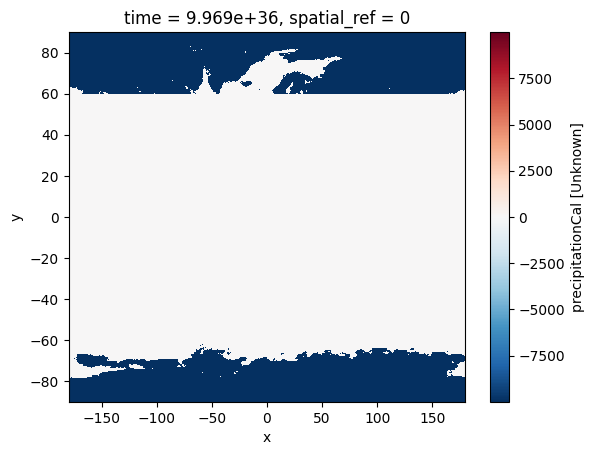

In [7]:
rds.precipitationCal.plot()

In [8]:
rds.precipitationCal.rio.to_raster('imerg.tiff')

In [95]:
def plot(lon, lat, values):
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from mpl_toolkits.basemap import Basemap

    #plot with Matplotlib
    fig=plt.figure(figsize=(20,20))
    # set the color interval
#     interval=list(np.arange(1,30,1)) 
#     interval.insert(0,0.1)
    #set colormap
    cmap = mpl.cm.get_cmap("jet").copy()
    cmap.set_under('w', alpha=0)
    #set map
    m=Basemap(projection='cyl',
            resolution='c',
            llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)
    m.drawcoastlines(color='black')
    m.drawmeridians(np.arange(0,360,30))
    m.drawparallels(np.arange(-90,90,30))
    x,y=m(Lon, Lat) #compute map projection
    im=plt.contourf(x,y,values, cmap=cmap) 
    # set colorbar
    cb=m.colorbar(im, "right", size="2.5%")
    # plt.show()

In [96]:
import netCDF4
nc=netCDF4.Dataset('imerge_.nc','r')
Lon=nc.variables['lon'][:]
Lat=nc.variables['lat'][:]
precipitationCal=nc.variables['precipitationCal'][:]
precipitationUncal=nc.variables['precipitationUncal'][:]
nc.close()

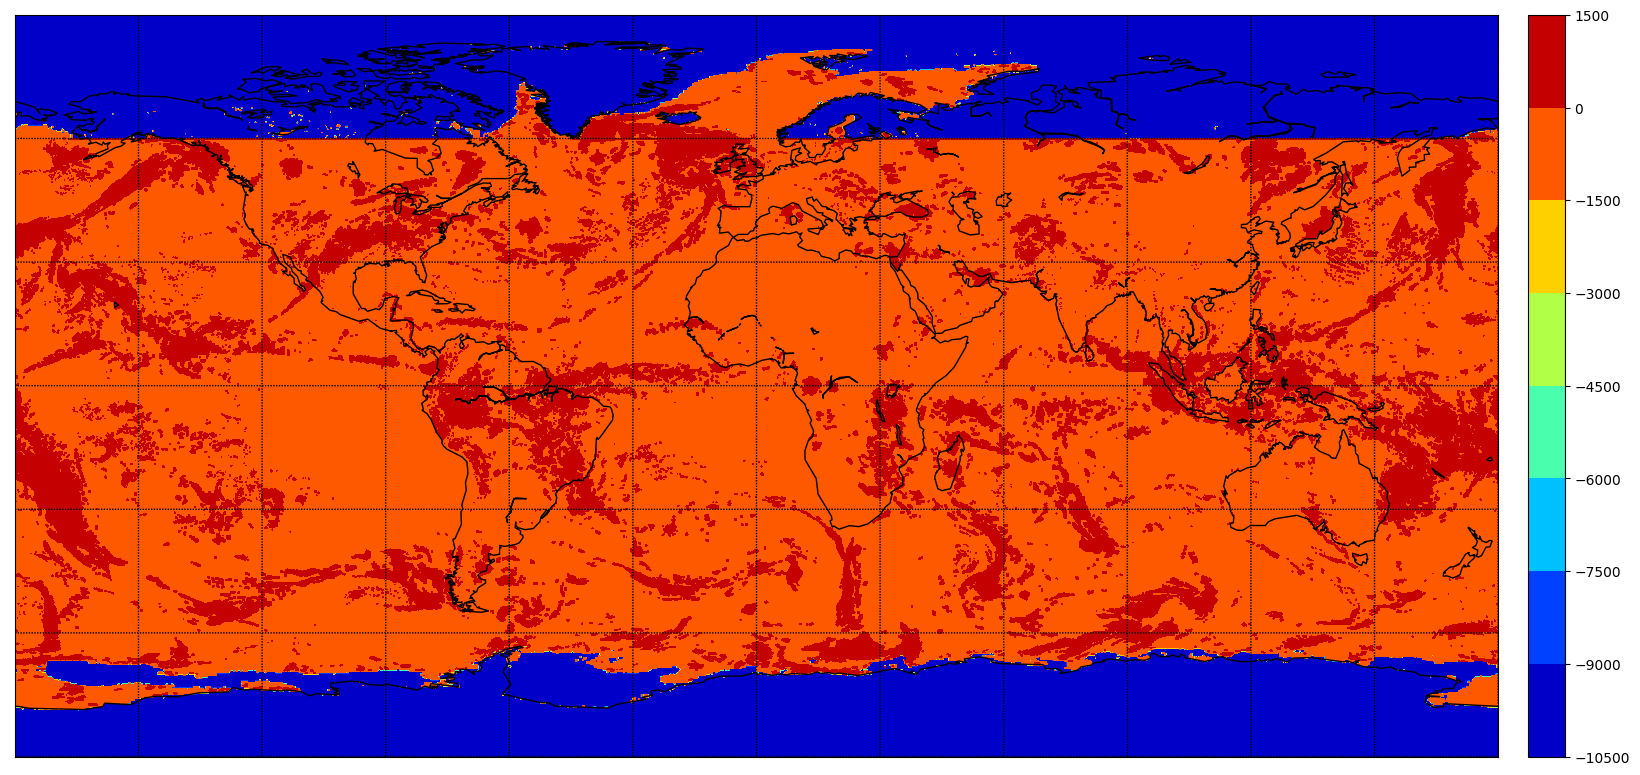

In [97]:
plot(Lon, Lat, precipitationCal[0])

In [ ]:
rioxarray.open_rasterio

## GSMaP

In [27]:
import rioxarray
import pandas as pd
rds = rioxarray.open_rasterio("data/gsmap/2022/01/01/gsmap_now_rain.20220101.0000.nc", decode_times=False)
units, reference_date = rds.Time.attrs['units'].split('since')
rds['Time'] = pd.date_range(start=reference_date, periods=rds.sizes['Time'], freq='MS')
rds.rio.write_crs('epsg:4326', inplace=True)
rds

<xarray.Dataset>
Dimensions:             (Time: 1, x: 3600, y: 1800)
Coordinates:
  * Time                (Time) datetime64[ns] 2022-01-01
  * x                   (x) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * y                   (y) float64 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
    spatial_ref         int64 0
Data variables:
    hourlyPrecipRate    (Time, y, x) float32 ...
    hourlyPrecipRateGC  (Time, y, x) float32 ...
Attributes:
    institution:  JAXA/EORC
    title:        GSMaP_NOW_V8

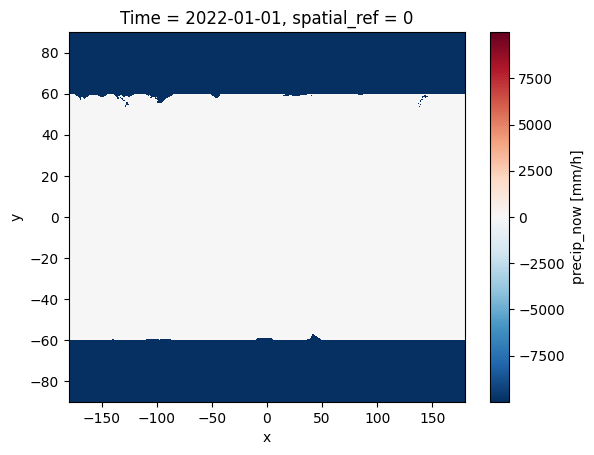

In [28]:
rds.hourlyPrecipRate.plot()

In [29]:
def get_shape():
    import shapefile
    shape = shapefile.Reader("data/shapefile/thailand/tha_admbnda_adm0_rtsd_20220121.shp")
    feature = shape.shapeRecords()[0]
    first = feature.shape.__geo_interface__
    return first
shp = get_shape()
clipped = rds.hourlyPrecipRateGC.rio.clip([shp])

# clipped
# cropping_geometries = [geometries]

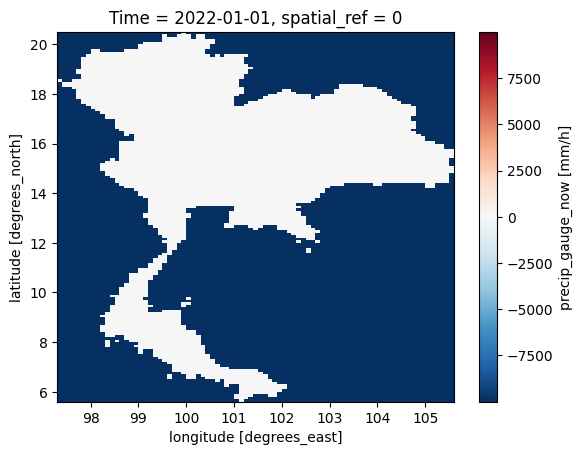

In [30]:
clipped.plot()

In [98]:
clipped.rio.to_raster('gsmap_thailand.tiff')

# GSMaP

In [1]:
import gzip
import numpy as np
import netCDF4 as nc


def get_gsmap_dat(filename:str) -> np.ndarray:
    gz = gzip.GzipFile(filename1,'rb')
    data=np.frombuffer(gz.read(),dtype=np.float32).reshape((1200,3600))
    return data
    
filename1='./data/gsmap/2022/01/01/gsmap_mvk.20220101.0000.v7.3112.0.dat.gz'

column_value = 'gsmap_mvk_hourly'
bounding_box = {
    'lat_range': [5.4, 20.6],
    'lon_range': [97.1, 106]
}

In [11]:
from glob import glob
from datetime import datetime, timedelta
path = glob(f"./data/gsmap/*/*/*")[0]
path.split('/')

['.', 'data', 'gsmap', '2022', '01', '01']

In [19]:
source_list

['./data/gsmap/2022/01/01/gsmap_mvk.20220101.0700.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.0800.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.0900.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.1000.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.1100.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.1200.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.1300.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.1400.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.1500.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.1600.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.1700.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.1800.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.1900.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mvk.20220101.2000.v7.3112.0.dat.gz',
 './data/gsmap/2022/01/01/gsmap_mv

In [18]:
source_list = []
timezone = '+7'
target_day = datetime(year=2022, month=1, day=1)
for i in range(0, 24):
    d1 = target_day + timedelta(hours=int(timezone), minutes=(i * 60))
    # gsmap_mvk.20220101.0000.v7.3112.0.dat.gz
    f1 = glob(f"./data/gsmap/{d1.strftime('%Y/%m/%d')}/*{d1.strftime('%Y%m%d.%H%M')}*.dat.gz")[0]
    source_list.append(f1)
# logger.debug(f"{source_list=}")
assert len(source_list) == 24, f"There should be 24 files but only {len(source_list)} is found. {source_list}"


In [ ]:
def create_netcdf(source_list:list[str], bounding_box:dict, column_value:str):
    
    lon_gen = np.linspace(0.05,359.95,3600)
    lat_gen = np.linspace(59.95,-59.95,1200)
    assert data.shape == (1200,3600) # (lat, lon)
    bound_lon = np.logical_and( lon_gen >= lon_range[0], lon_gen <= lon_range[1])
    bound_lat = np.logical_and(lat_gen >= lat_range[0], lat_gen <= lat_range[1])

    ds = nc.Dataset('./temp/imerg-2023-002.nc', 'w', format='NETCDF4')
    time = ds.createDimension('time', 1)
    lat = ds.createDimension('lat', sum(bound_lat))
    lon = ds.createDimension('lon', sum(bound_lon))
    times = ds.createVariable('time', 'f4', ('time',))
    lats = ds.createVariable('lat', 'f4', ('lat',))
    lons = ds.createVariable('lon', 'f4', ('lon',))
    values = ds.createVariable(column_value, 'f4', ('time', 'lat', 'lon',))
    values.units = 'Unknown'
    lats[:] = list(lat_gen[bound_lat])
    lons[:] = list(lon_gen[bound_lon])

    bounded = h['Grid'][column_value][0][bound_lon]
    bounded = bounded[:, bound_lat]
    data = bounded.copy()

    for f in files:
        if(f == files[0]): continue
        h = h5py.File(f,'r')
        bounded = h['Grid'][column_value][0][bound_lon]
        bounded = bounded[:, bound_lat]
        data += bounded
        h.close()

    data = data * 10
    data[data < 0] = 29999
    values[0, :, :] = np.expand_dims(data.T, 0)
    ds.close()